# DiffEdit

A [Hugging Face](https://huggingface.co/docs/diffusers/en/using-diffusers/diffedit) implementation of the [`DiffEdit`](https://arxiv.org/abs/2210.11427) technique, with [Unsplash](https://unsplash.com) photos.

You'll need a GPU for running this notebook, if you're on Colab makes sure to select an appropriate runtime.

Note: unfortunately, we cannot use stable diffusion 3 because the current hugging face pipeline doesn't support it yet.

In [1]:
!pip install -q diffusers transformers accelerate huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 43.7 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline
from diffusers.utils import load_image, make_image_grid
from PIL import Image
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import BlipForConditionalGeneration, BlipProcessor

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

@torch.no_grad()
def generate_prompts(input_prompt):
    input_ids = tokenizer(input_prompt, return_tensors="pt").input_ids.to("cuda")

    outputs = t5_model.generate(
        input_ids, temperature=0.8, num_return_sequences=16, do_sample=True, max_new_tokens=128, top_k=10
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

@torch.no_grad()
def embed_prompts(sentences, tokenizer, text_encoder, device="cuda"):
    embeddings = []
    for sent in sentences:
        text_inputs = tokenizer(
            sent,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        prompt_embeds = text_encoder(text_input_ids.to(device), attention_mask=None)[0]
        embeddings.append(prompt_embeds)
    return torch.concatenate(embeddings, dim=0).mean(dim=0).unsqueeze(0)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [4]:
pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16,
    safety_checker=None,
    use_safetensors=True,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


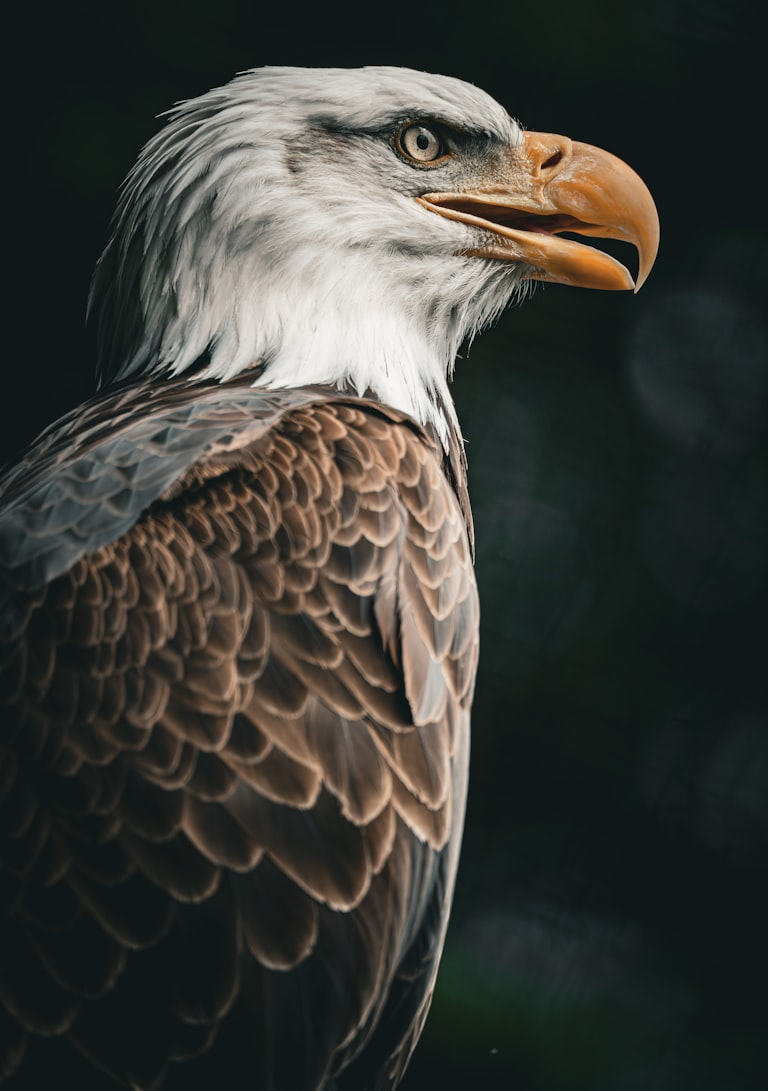

In [5]:
img_url = "https://images.unsplash.com/photo-1719437492355-9686ac0bb4d9?q=80&w=768&auto=format&fit=crop"
raw_image = load_image(img_url)
raw_image

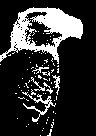

In [7]:
source_concept = "a complete full-body bald eagle"
target_concept = "a complete full-body realistic hawk"

# source_text = f"Provide a caption for images containing a {source_concept}. "
# "The captions should be in English and should be no longer than 150 characters."

# target_text = f"Provide a caption for images containing a {target_concept}. "
# "The captions should be in English and should be no longer than 150 characters."


# source_prompts = generate_prompts(source_text)
# target_prompts = generate_prompts(target_text)

# source_embeds = embed_prompts(source_prompts, pipeline.tokenizer, pipeline.text_encoder)
# target_embeds = embed_prompts(target_prompts, pipeline.tokenizer, pipeline.text_encoder)


mask_image = pipeline.generate_mask(
    image=raw_image,
    source_prompt=source_concept,
    target_prompt=target_concept,
    target_negative_prompt="cartoon, anime, ugly",
    # source_prompt_embeds=source_embeds,
    # target_prompt_embeds=target_embeds,
    num_inference_steps=100
)
Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L")

In [8]:
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16, low_cpu_mem_usage=True)

@torch.no_grad()
def generate_caption(images, caption_generator, caption_processor):
    text = "a photograph of"

    inputs = caption_processor(images, text, return_tensors="pt").to(device="cuda", dtype=caption_generator.dtype)
    caption_generator.to("cuda")
    outputs = caption_generator.generate(**inputs, max_new_tokens=128)

    # offload caption generator
    caption_generator.to("cpu")

    caption = caption_processor.batch_decode(outputs, skip_special_tokens=True)[0]
    return caption

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
caption = generate_caption(raw_image, blip_model, blip_processor)

In [17]:
inv_latents = pipeline.invert(prompt="a realistic photograph of an eagle on a black background",
                              negative_prompt="cartoon, anime, ugly",
                              image=raw_image,
                              num_inference_steps=100).latents

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

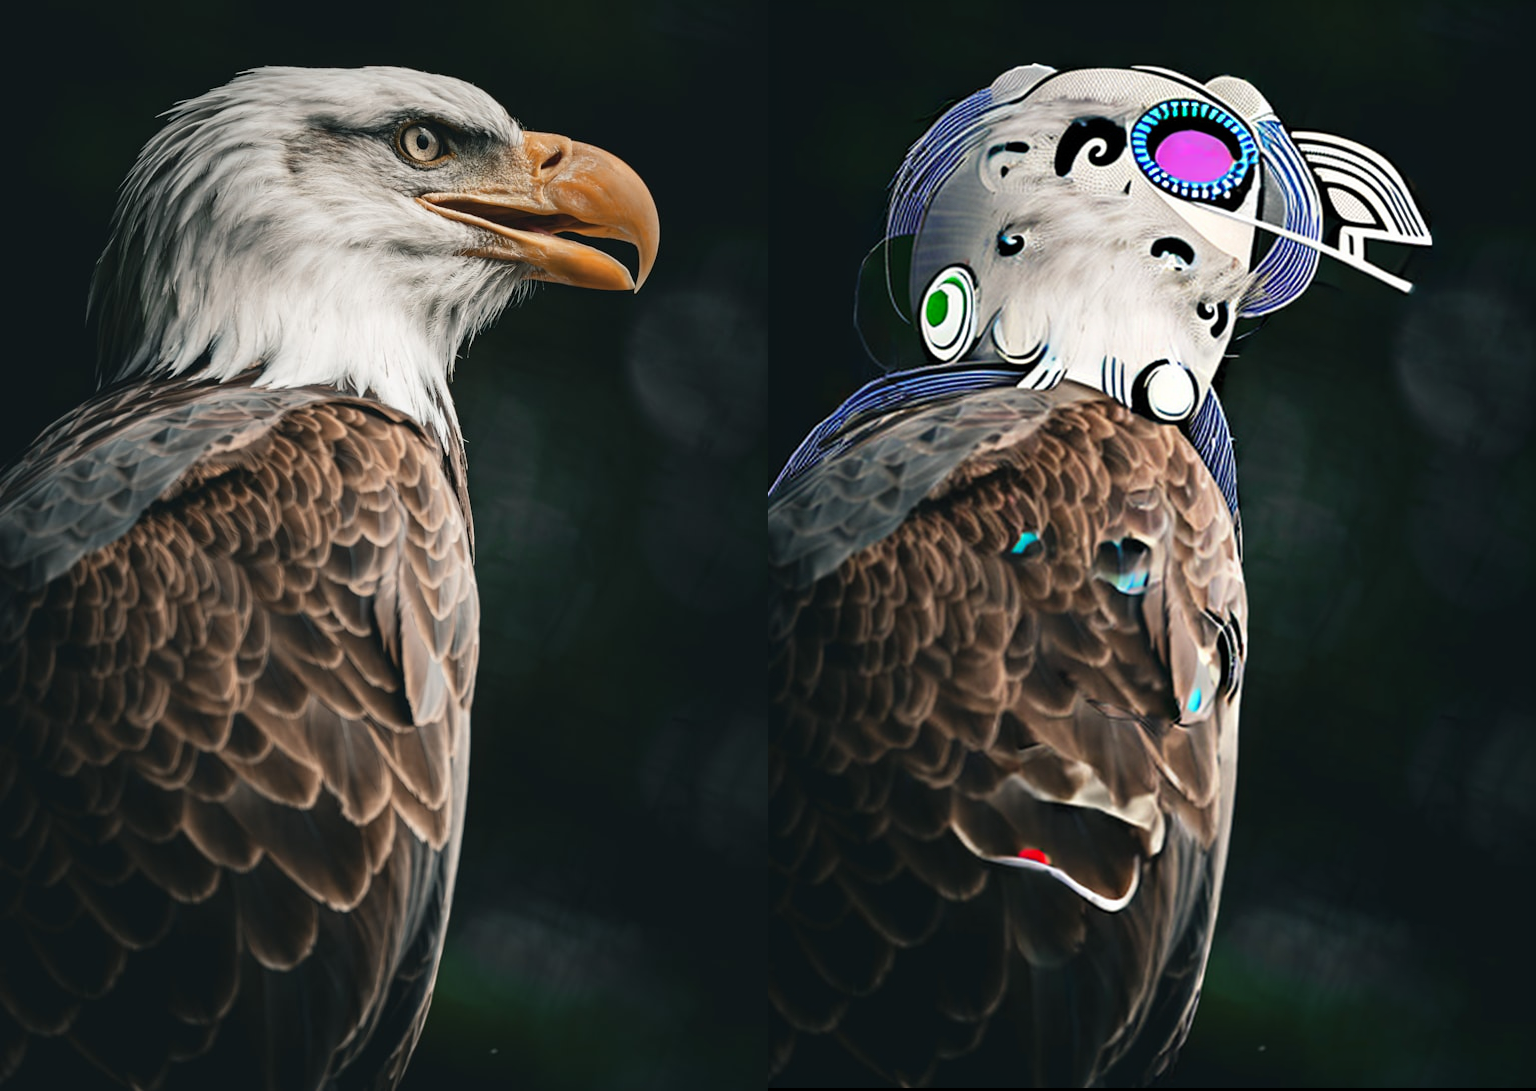

In [22]:
output_image = pipeline(
    prompt=target_concept,
    negative_prompt=f"${source_concept}, cartoon, anime, ugly",
    mask_image=mask_image,
    image_latents=inv_latents,
    num_inference_steps=100
).images[0]

make_image_grid([raw_image, output_image], rows=1, cols=2)